In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

In [ ]:
#importing dataset
dataset_directory = os.listdir('/content/drive/MyDrive/Plant_Village_data/PotatoLeafImage_data')
for filenames in dataset_directory:
    print(filenames)

Potato___Late_blight
Potato___healthy
Potato___Early_blight


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import cv2

In [ ]:
#Global initialization of some imp variables
Image_Size = 224
Batch_Size = 16
Channels = 3

In [ ]:
dataset_directory = '/content/drive/MyDrive/Plant_Village_data/PotatoLeafImage_data'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,  # this should be a string, not a list
    batch_size=Batch_Size,
    image_size=(Image_Size, Image_Size),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [ ]:
#Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset) # Number of Batches = (total number of files belonging to all classes / Batch_Size)

135

In [ ]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)

    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds


In [ ]:
train_data, val_data, test_data = split_dataset(dataset)

In [ ]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :135 
Batch size of Training Data is :108
Batch size of Validation Data is :13 
Batch size of Testing Data is :14 


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model


In [ ]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# Define the data augmentation in a Sequential model
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
  layers.experimental.preprocessing.RandomContrast(factor=0.2)
])

In [ ]:
train_ds = train_data.cache().shuffle(1000).map(
  lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)

base_model = tf.keras.applications.InceptionV3(input_shape=(Image_Size, Image_Size, Channels),
                                               include_top=False,
                                               weights='imagenet')

# Freezing the base model
base_model.trainable = False

# Creating the InceptionV3 model
mdL_inceptionv3 = tf.keras.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation='softmax')
])
mdL_inceptionv3.build(input_shape = input_shape)
mdL_inceptionv3.summary()

87910968/87910968 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 224, 224, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (16, 2048)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (16, 3)                   6147      
                                                                 
Total params: 21808931 (83.19 MB)
Trainable params: 6147 (24.01 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
mdL_inceptionv3.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history1_inceptionv3 = mdL_inceptionv3.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
108/108 [==============================] - 52s 353ms/step - loss: 0.5559 - accuracy: 0.7628 - val_loss: 0.3475 - val_accuracy: 0.9038
Epoch 2/200
108/108 [==============================] - 33s 308ms/step - loss: 0.3245 - accuracy: 0.8733 - val_loss: 0.3019 - val_accuracy: 0.8990
Epoch 3/200
108/108 [==============================] - 31s 291ms/step - loss: 0.2994 - accuracy: 0.8820 - val_loss: 0.2599 - val_accuracy: 0.9038
Epoch 4/200
108/108 [==============================] - 31s 288ms/step - loss: 0.2311 - accuracy: 0.9186 - val_loss: 0.2739 - val_accuracy: 0.9038
Epoch 5/200
108/108 [==============================] - 31s 288ms/step - loss: 0.2278 - accuracy: 0.9116 - val_loss: 0.2762 - val_accuracy: 0.8942
Epoch 6/200
108/108 [==============================] - 31s 287ms/step - loss: 0.2201 - accuracy: 0.9192 - val_loss: 0.2237 - val_accuracy: 0.9183
Epoch 7/200
108/108 [==============================] - 31s 289ms/step - loss: 0.2071 - accuracy: 0.9215 - val_loss: 0.2135 -

In [ ]:
# Getting the model history to analyse
train_loss = history1_inceptionv3.history['loss']
train_acc = history1_inceptionv3.history['accuracy']

val_loss = history1_inceptionv3.history['val_loss']
val_acc = history1_inceptionv3.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

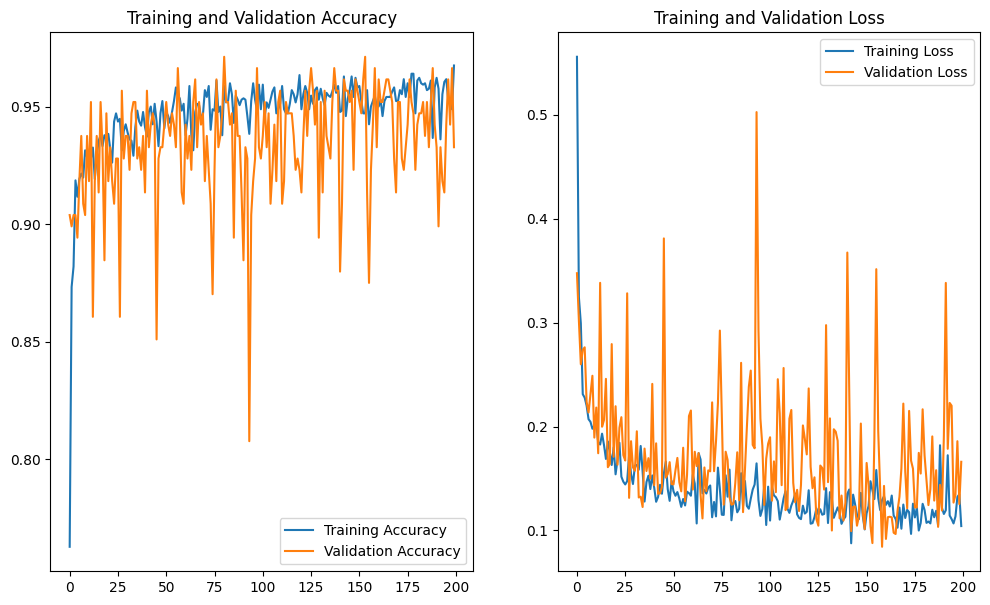

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
mdL_inceptionv3.save('/content/drive/My Drive/mdL_inceptionv3')

In [ ]:
model_path = '/content/drive/My Drive/mdL_inceptionv3'
Model_InceptionV3 = tf.keras.models.load_model(model_path)

In [ ]:
scores = Model_InceptionV3.evaluate(test_ds)

14/14 [==============================] - 16s 1s/step - loss: 0.1852 - accuracy: 0.9286


In [ ]:
predictions = Model_InceptionV3.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = []
for _, y in test_ds:
    true_labels.extend(y.numpy())

# Convert list to numpy array
true_labels = np.array(true_labels)

14/14 [==============================] - 19s 1s/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Classification report for precision, recall, f1-score
report = classification_report(true_labels, predicted_labels, target_names=['Potato Early Blight', 'Potato Late Blight', 'Potato Healthy'])
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

                     precision    recall  f1-score   support

Potato Early Blight       0.91      0.99      0.95       116
 Potato Late Blight       1.00      0.85      0.92        97
     Potato Healthy       0.69      1.00      0.81        11

           accuracy                           0.93       224
          macro avg       0.87      0.95      0.89       224
       weighted avg       0.94      0.93      0.93       224

[[115   0   1]
 [ 11  82   4]
 [  0   0  11]]
Accuracy: 0.9285714285714286


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels
y_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Calculate AUC-ROC
# The "ovr" means "one versus rest"
roc_auc = roc_auc_score(y_binarized, predictions, multi_class='ovr')
print(f'AUC-ROC: {roc_auc}')

AUC-ROC: 0.9953968577638288


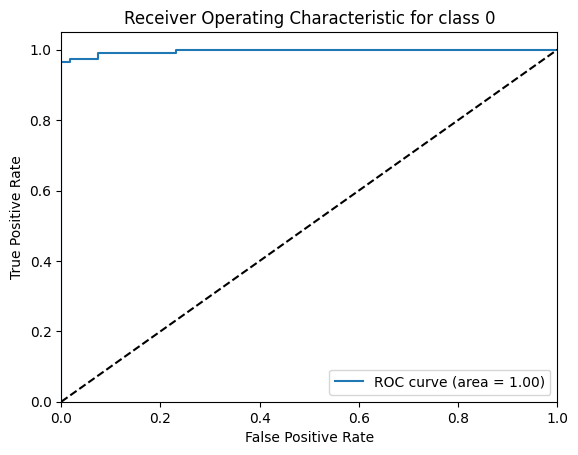

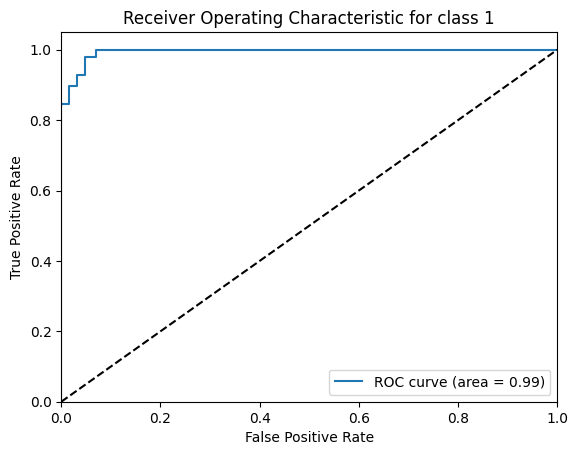

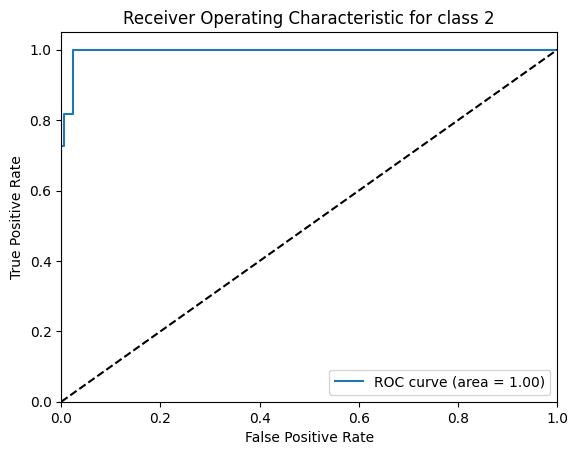

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(y_binarized[:, i], predictions[:, i])

# Plotting
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)

base_model = tf.keras.applications.MobileNetV2(input_shape=(Image_Size, Image_Size, Channels),
                                               include_top=False,
                                               weights='imagenet')

# Freezing the base model
base_model.trainable = False

# Creating the MobileNetV2 model
mdL_Mobilenetv2 = tf.keras.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation='softmax')
])
mdL_Mobilenetv2.build(input_shape = input_shape)
mdL_Mobilenetv2.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (16, 1280)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (16, 3)                   3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________

In [ ]:
mdL_Mobilenetv2.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history1_mobilenetv2 = mdL_Mobilenetv2.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
108/108 [==============================] - 33s 265ms/step - loss: 0.3861 - accuracy: 0.8564 - val_loss: 0.2249 - val_accuracy: 0.9231
Epoch 2/200
108/108 [==============================] - 27s 254ms/step - loss: 0.1869 - accuracy: 0.9436 - val_loss: 0.1706 - val_accuracy: 0.9663
Epoch 3/200
108/108 [==============================] - 29s 269ms/step - loss: 0.1353 - accuracy: 0.9523 - val_loss: 0.1375 - val_accuracy: 0.9519
Epoch 4/200
108/108 [==============================] - 27s 254ms/step - loss: 0.1216 - accuracy: 0.9581 - val_loss: 0.1325 - val_accuracy: 0.9615
Epoch 5/200
108/108 [==============================] - 27s 254ms/step - loss: 0.1290 - accuracy: 0.9610 - val_loss: 0.1218 - val_accuracy: 0.9712
Epoch 6/200
108/108 [==============================] - 27s 252ms/step - loss: 0.1040 - accuracy: 0.9669 - val_loss: 0.1116 - val_accuracy: 0.9712
Epoch 7/200
108/108 [==============================] - 28s 256ms/step - loss: 0.1081 - accuracy: 0.9599 - val_loss: 0.1409 -

In [ ]:
# Getting the model history to analyse
train_loss = history1_mobilenetv2.history['loss']
train_acc = history1_mobilenetv2.history['accuracy']

val_loss = history1_mobilenetv2.history['val_loss']
val_acc = history1_mobilenetv2.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

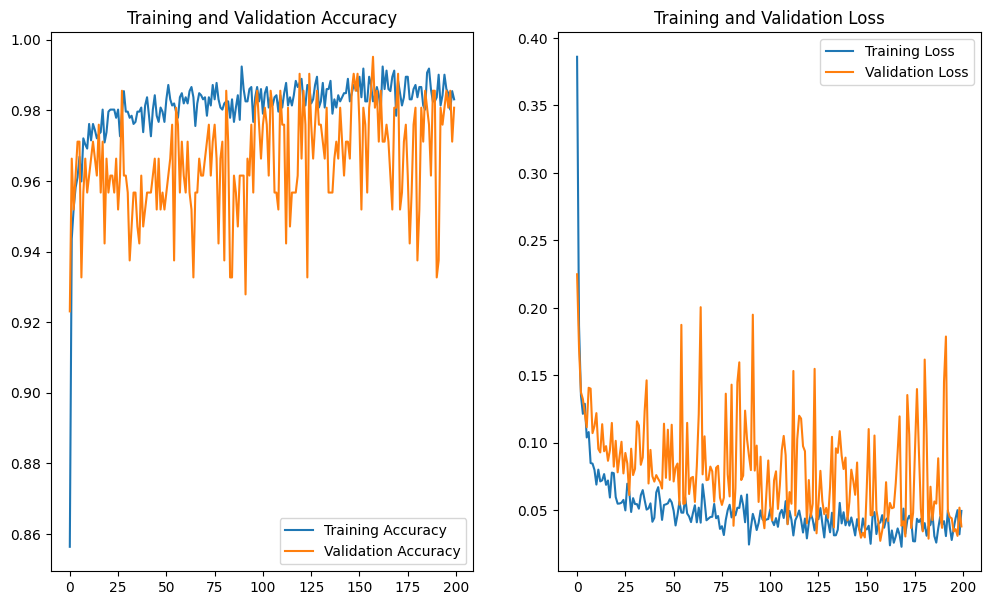

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
mdL_Mobilenetv2.save('/content/drive/My Drive/mdL_Mobilenetv2')

In [ ]:
model_path = '/content/drive/My Drive/mdL_Mobilenetv2'
Model_MobilNetV2 = tf.keras.models.load_model(model_path)

In [ ]:
scores = Model_MobilNetV2.evaluate(test_ds)

14/14 [==============================] - 5s 309ms/step - loss: 0.0299 - accuracy: 0.9866


In [ ]:
predictions = Model_MobilNetV2.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = []
for _, y in test_ds:
    true_labels.extend(y.numpy())

# Convert list to numpy array
true_labels = np.array(true_labels)

14/14 [==============================] - 6s 397ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Classification report for precision, recall, f1-score
report = classification_report(true_labels, predicted_labels, target_names=['Potato Early Blight', 'Potato Late Blight', 'Potato Healthy'])
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

                     precision    recall  f1-score   support

Potato Early Blight       0.99      1.00      1.00       116
 Potato Late Blight       1.00      0.97      0.98        97
     Potato Healthy       0.85      1.00      0.92        11

           accuracy                           0.99       224
          macro avg       0.95      0.99      0.97       224
       weighted avg       0.99      0.99      0.99       224

[[116   0   0]
 [  1  94   2]
 [  0   0  11]]
Accuracy: 0.9866071428571429


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels
y_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Calculate AUC-ROC
# The "ovr" means "one versus rest"
roc_auc = roc_auc_score(y_binarized, predictions, multi_class='ovr')
print(f'AUC-ROC: {roc_auc}')

AUC-ROC: 0.9998922175130803


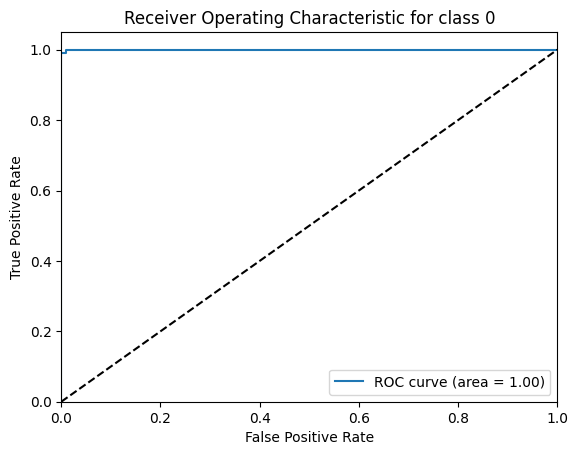

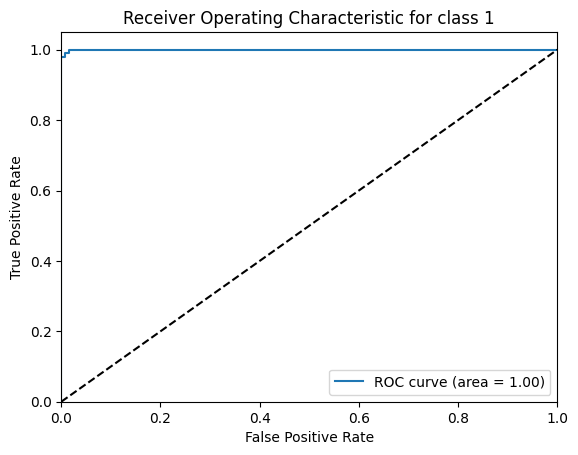

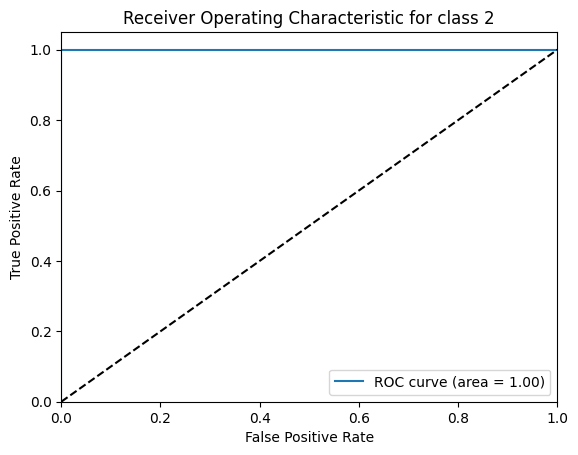

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(y_binarized[:, i], predictions[:, i])

# Plotting
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# MobileNet Pre-trained Model
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)

base_model = tf.keras.applications.MobileNet(input_shape=(Image_Size, Image_Size, Channels),
                                               include_top=False,
                                               weights='imagenet')

# Freezing the base model
base_model.trainable = False

# Creating the MobileNet model
mdL_mobilenet = tf.keras.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation='softmax')
])
mdL_mobilenet.build(input_shape = input_shape)
mdL_mobilenet.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (16, 1024)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (16, 3)                   3075      
                                                                 
Total params: 3231939 (12.33 MB)
Trainable params: 3075 (12.01 KB)
Non-trainable params: 3228864 (12.32 MB)
_____________

In [ ]:
mdL_mobilenet.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history1_mobilenet = mdL_mobilenet.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
108/108 [==============================] - 31s 263ms/step - loss: 0.4559 - accuracy: 0.8157 - val_loss: 0.3092 - val_accuracy: 0.8510
Epoch 2/200
108/108 [==============================] - 28s 262ms/step - loss: 0.2022 - accuracy: 0.9372 - val_loss: 0.1668 - val_accuracy: 0.9471
Epoch 3/200
108/108 [==============================] - 28s 261ms/step - loss: 0.1737 - accuracy: 0.9372 - val_loss: 0.1129 - val_accuracy: 0.9760
Epoch 4/200
108/108 [==============================] - 30s 274ms/step - loss: 0.1357 - accuracy: 0.9587 - val_loss: 0.1523 - val_accuracy: 0.9567
Epoch 5/200
108/108 [==============================] - 29s 264ms/step - loss: 0.1206 - accuracy: 0.9576 - val_loss: 0.0807 - val_accuracy: 0.9760
Epoch 6/200
108/108 [==============================] - 27s 246ms/step - loss: 0.1249 - accuracy: 0.9564 - val_loss: 0.1026 - val_accuracy: 0.9760
Epoch 7/200
108/108 [==============================] - 28s 255ms/step - loss: 0.0950 - accuracy: 0.9703 - val_loss: 0.0746 -

In [ ]:
# Getting the model history to analyse
train_loss = history1_mobilenet.history['loss']
train_acc = history1_mobilenet.history['accuracy']

val_loss = history1_mobilenet.history['val_loss']
val_acc = history1_mobilenet.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

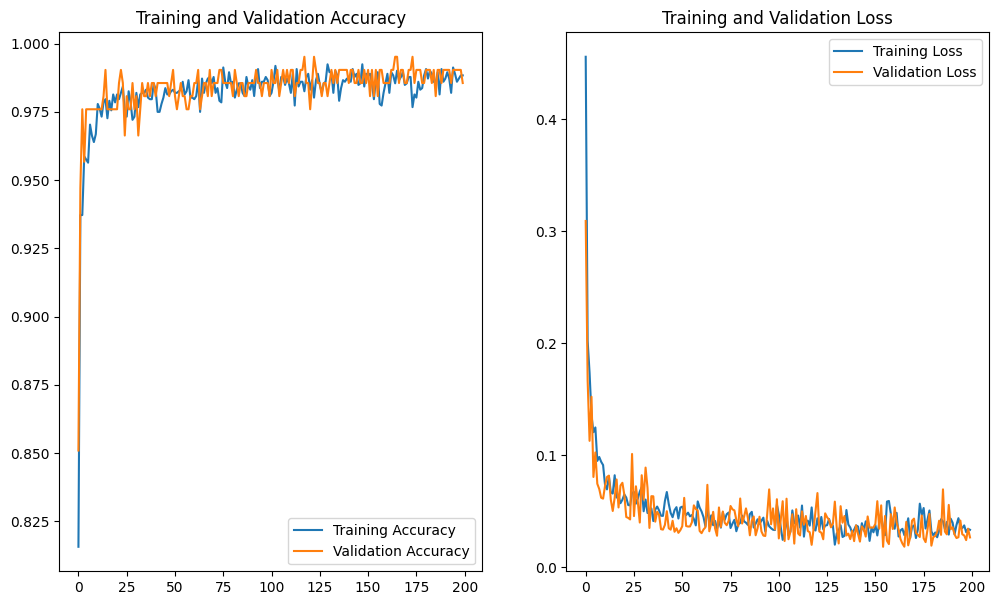

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
mdL_mobilenet.save('/content/drive/My Drive/mdL_Mobilenet')

In [ ]:
model_path = '/content/drive/My Drive/mdL_Mobilenet'
Model_MobilNet = tf.keras.models.load_model(model_path)

In [ ]:
scores = Model_MobilNet.evaluate(test_ds)

14/14 [==============================] - 8s 565ms/step - loss: 0.0154 - accuracy: 0.9911


In [ ]:
predictions = Model_MobilNet.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = []
for _, y in test_ds:
    true_labels.extend(y.numpy())

# Convert list to numpy array
true_labels = np.array(true_labels)

14/14 [==============================] - 6s 416ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Classification report for precision, recall, f1-score
report = classification_report(true_labels, predicted_labels, target_names=['Potato Early Blight', 'Potato Late Blight', 'Potato Healthy'])
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

                     precision    recall  f1-score   support

Potato Early Blight       1.00      0.99      1.00       116
 Potato Late Blight       0.99      0.99      0.99        97
     Potato Healthy       0.92      1.00      0.96        11

           accuracy                           0.99       224
          macro avg       0.97      0.99      0.98       224
       weighted avg       0.99      0.99      0.99       224

[[115   1   0]
 [  0  96   1]
 [  0   0  11]]
Accuracy: 0.9910714285714286


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels
y_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Calculate AUC-ROC
# The "ovr" means "one versus rest"
roc_auc = roc_auc_score(y_binarized, predictions, multi_class='ovr')
print(f'AUC-ROC: {roc_auc}')

AUC-ROC: 0.9999729415266391


In [ ]:
# ResNet50 Pre-trained Model
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)

base_model = tf.keras.applications.ResNet50(input_shape=(Image_Size, Image_Size, Channels),
                                               include_top=False,
                                               weights='imagenet')

# Freezing the base model
base_model.trainable = False

# Creating the ResNet50 model
mdL_resnet50 = tf.keras.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation='softmax')
])
mdL_resnet50.build(input_shape = input_shape)
mdL_resnet50.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 224, 224, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (16, 2048)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (16, 3)                   6147      
                                                                 
Total params: 23593859 (90.00 MB)
Trainable params: 6147 (24.01 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
mdL_resnet50.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history1_resnet50 = mdL_resnet50.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
108/108 [==============================] - 342s 353ms/step - loss: 0.8940 - accuracy: 0.5262 - val_loss: 0.8917 - val_accuracy: 0.6971
Epoch 2/200
108/108 [==============================] - 33s 302ms/step - loss: 0.8412 - accuracy: 0.6233 - val_loss: 0.8425 - val_accuracy: 0.5962
Epoch 3/200
108/108 [==============================] - 32s 299ms/step - loss: 0.8252 - accuracy: 0.6384 - val_loss: 0.8112 - val_accuracy: 0.6875
Epoch 4/200
108/108 [==============================] - 32s 299ms/step - loss: 0.8042 - accuracy: 0.6483 - val_loss: 0.8511 - val_accuracy: 0.5673
Epoch 5/200
108/108 [==============================] - 34s 312ms/step - loss: 0.7930 - accuracy: 0.6669 - val_loss: 0.8437 - val_accuracy: 0.6587
Epoch 6/200
108/108 [==============================] - 32s 297ms/step - loss: 0.7650 - accuracy: 0.6860 - val_loss: 0.8599 - val_accuracy: 0.5769
Epoch 7/200
108/108 [==============================] - 32s 301ms/step - loss: 0.7570 - accuracy: 0.6802 - val_loss: 0.7580 

In [ ]:
mdL_resnet50.save('/content/drive/My Drive/mdL_resnet')

In [ ]:
model_path = '/content/drive/My Drive/mdL_resnet'
Model_ResNet50 = tf.keras.models.load_model(model_path)

In [ ]:
scores = Model_ResNet50.evaluate(test_ds)

14/14 [==============================] - 27s 2s/step - loss: 0.6376 - accuracy: 0.7321


In [ ]:
# Getting the model history to analyse
train_loss = history1_resnet50.history['loss']
train_acc = history1_resnet50.history['accuracy']

val_loss = history1_resnet50.history['val_loss']
val_acc = history1_resnet50.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

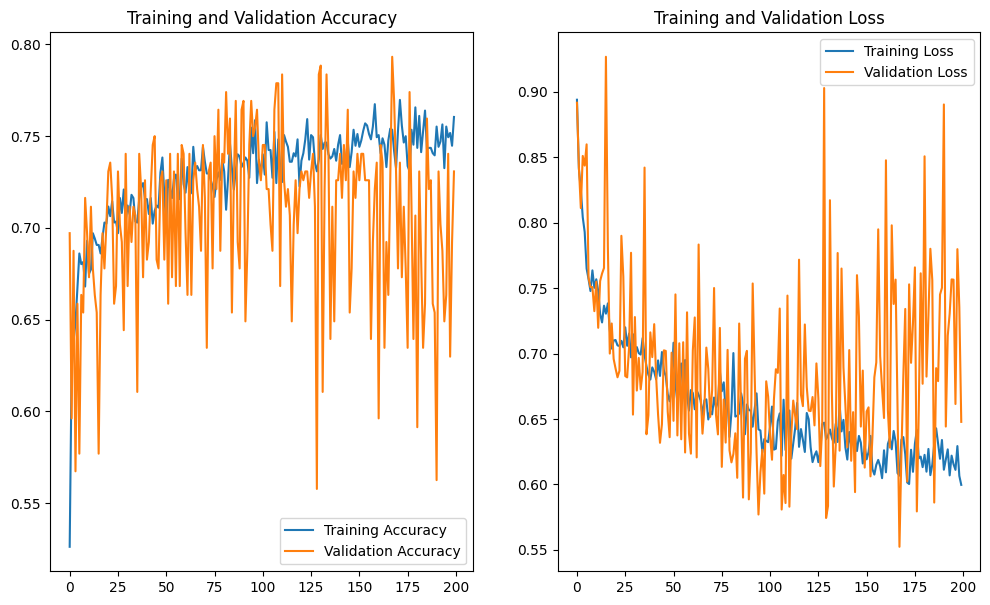

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
predictions = Model_ResNet50.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = []
for _, y in test_ds:
    true_labels.extend(y.numpy())

# Convert list to numpy array
true_labels = np.array(true_labels)

14/14 [==============================] - 26s 2s/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Classification report for precision, recall, f1-score
report = classification_report(true_labels, predicted_labels, target_names=['Potato Early Blight', 'Potato Late Blight', 'Potato Healthy'])
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

                     precision    recall  f1-score   support

Potato Early Blight       0.83      0.82      0.83       116
 Potato Late Blight       0.95      0.63      0.76        97
     Potato Healthy       0.17      0.73      0.28        11

           accuracy                           0.73       224
          macro avg       0.65      0.73      0.62       224
       weighted avg       0.85      0.73      0.77       224

[[95  3 18]
 [16 61 20]
 [ 3  0  8]]
Accuracy: 0.7321428571428571


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels
y_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Calculate AUC-ROC
# The "ovr" means "one versus rest"
roc_auc = roc_auc_score(y_binarized, predictions, multi_class='ovr')
print(f'AUC-ROC: {roc_auc}')

AUC-ROC: 0.8940043554418905
